In [4]:
#스마트 폰을 사용한 인간 활동 인식 데이터 세트
#서 30 명의 지원자 그룹
#각 사람은 허리에 스마트 폰 (삼성 갤럭시 S II)을 착용하고 6 가지 활동 (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING)을 수행했습니다. 내장 된 가속도계와 자이로 스코프를 사용하여 50Hz의 일정한 속도로 3 축 선형 가속도와 3 축 각속도를 캡처했습니다. 실험은 데이터에 수동으로 레이블을 지정하기 위해 비디오로 녹화되었습니다. 획득 한 데이터 세트는 무작위로 두 세트로 분할되었으며, 지원자의 70 %가 훈련 데이터 생성을 위해 선택되었고 30 %가 테스트 데이터를 생성했습니다.

###############RandomForest####################
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# features.txt 파일에는 피처 이름 index와 피처명이 공백으로 분리되어 있음. 이를 DataFrame으로 로드.
feature_name_df = pd.read_csv('./human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])

# 피처명 index를 제거하고, 피처명만 리스트 객체로 생성한 뒤 샘플로 10개만 추출
feature_name = feature_name_df.iloc[:, 1].values.tolist()
print('전체 특성에서 10개  추출:', feature_name[:10])


#중복 피처 이름 확인 
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index'] > 1].count())
feature_dup_df[feature_dup_df['column_index'] > 1].head()

전체 특성에서 10개  추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']
column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [5]:
#중복 컬럼을 삭제한 데이터프레임을 가져오는 함수
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

#데이터를 가져오는 함수
import pandas as pd

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test


#함수 이용해 가져오기
X_train, X_test, y_train, y_test = get_human_dataset()


print('## 학습 feature dataset 정보')
print(X_train.info())

 
print(y_train['action'].value_counts())

## 학습 feature dataset 정보
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None
6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_dataset( )을 이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train , y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test , pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))


from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# 결정 트리 학습 및 별도의 테스트 셋으로 예측 성능 평가 
dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train , y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test , pred)
print('결정 트리 예측 정확도: {0:.4f}'.format(accuracy))

# DecisionTreeClassifier의 하이퍼 파라미터 추출
print('DecisionTreeClassifier 기본 하이퍼 파라미터:\n', dt_clf.get_params())

랜덤 포레스트 정확도: 0.9253
결정 트리 예측 정확도: 0.8548
DecisionTreeClassifier 기본 하이퍼 파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 156, 'splitter': 'best'}


In [8]:
##########랜덤 포레스트 하이퍼 파라미터 찾기 ###########
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100],
    'max_depth' : [6, 8, 10, 12], 
    'min_samples_leaf' : [8, 12, 18 ],
    'min_samples_split' : [8, 16, 20]
}

#최적 하이퍼 파라미터 출력
#최적 하이퍼 파라미터일때의 예측 정확도 출력
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf , param_grid=params , cv=2, n_jobs=-1 )
grid_cv.fit(X_train , y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최적 하이퍼 파라미터 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최적 하이퍼 파라미터 예측 정확도: 0.9180


In [9]:
########feature별 중요도 출력(시각화)#################
rf_clf1 = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=8, \
                                 min_samples_split=8, random_state=0)
rf_clf1.fit(X_train , y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))

예측 정확도: 0.9165


In [10]:
#####보팅 분류기(Voting Classifier) 실습 ##########
import pandas as pd
from sklearn.ensemble import VotingClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()
data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head()

lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier()

vo_clf = VotingClassifier(estimators=[('LR', lr_clf), ('KNN', knn_clf)], voting='soft')

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=156)

vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print ("Voting 분류기 정확도 : {0:.4f}".format(accuracy_score(y_test, pred)))


classifiers = [lr_clf, knn_clf]
for classifier in classifiers :
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print ("{0}분류기 정확도 : {1:.4f}".format(class_name, accuracy_score(y_test, pred)))

Voting 분류기 정확도 : 0.9474
LogisticRegression분류기 정확도 : 0.9386
KNeighborsClassifier분류기 정확도 : 0.9035


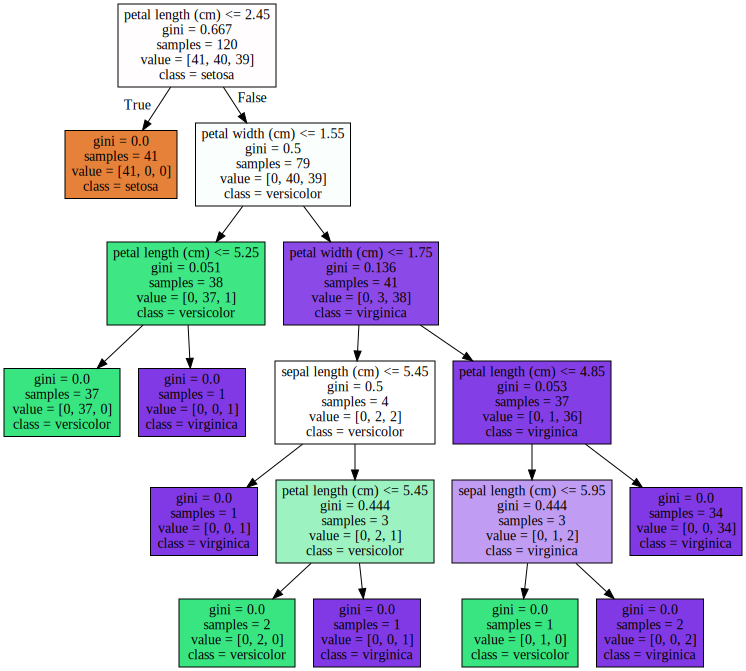

In [11]:
##############################################
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# DecisionTree Classifier 생성
dt_clf = DecisionTreeClassifier(random_state=156)

# 붓꽃 데이터를 로딩하고, 학습과 테스트 데이터 셋으로 분리
iris_data = load_iris()
X_train , X_test , y_train , y_test = train_test_split(iris_data.data, iris_data.target,
                                                       test_size=0.2,  random_state=11)

# DecisionTreeClassifer 학습. 
dt_clf.fit(X_train , y_train)




from sklearn.tree import export_graphviz

# export_graphviz()의 호출 결과로 out_file로 지정된 tree.dot 파일을 생성함. 
export_graphviz(dt_clf, out_file="tree.dot", class_names=iris_data.target_names , \
feature_names = iris_data.feature_names, impurity=True, filled=True)


import graphviz

# 위에서 생성된 tree.dot 파일을 Graphviz 읽어서 Jupyter Notebook상에서 시각화 
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

Feature importance:
[0.025 0.    0.555 0.42 ]
sepal length (cm) : 0.025
sepal width (cm) : 0.000
petal length (cm) : 0.555
petal width (cm) : 0.420


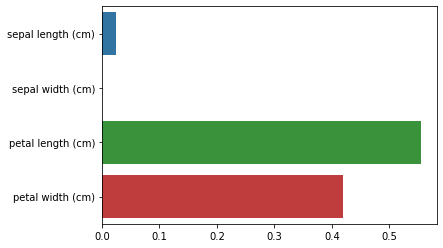

In [12]:
####특성별 분류 기준 중요도 출력 및 시각화 ################
import seaborn as sns
import numpy as np
%matplotlib inline

print("Feature importance:\n{0}".format(np.round(dt_clf.feature_importances_ , 3)))

#feature별 importance매핑
for name, value in zip(iris_data.feature_names, dt_clf.feature_importances_):
    print('{0} : {1:.3f}'.format(name, value))

sns.barplot(x=dt_clf.feature_importances_, y=iris_data.feature_names)

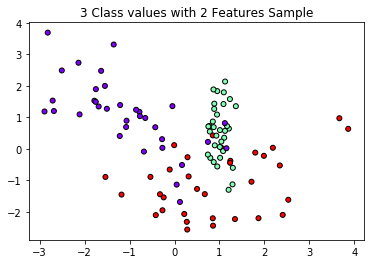

In [13]:
##########결정트리의 과적합 제어 #################
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

#feature는 2개, 결정값 클래스 3개 
X_features, y_labels = make_classification(n_features=2, n_redundant=0, n_informative=2, n_classes=3, n_clusters_per_class=1, random_state=0)

plt.title("3 Class values with 2 Features Sample")

plt.scatter(X_features[:, 0], X_features[:, 1], marker='o', c=y_labels, s=25, cmap='rainbow', edgecolor='k')

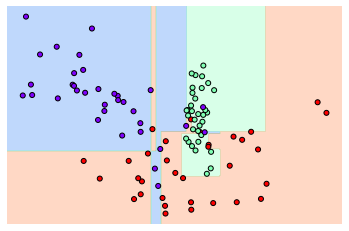

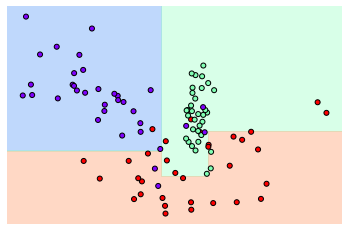

In [14]:
# Classifier의 Decision Boundary를 시각화 하는 함수
def visualize_boundary(model, X, y):
    fig,ax = plt.subplots()
    
    # 학습 데이타 scatter plot으로 나타내기
    ax.scatter(X[:, 0], X[:, 1], c=y, s=25, cmap='rainbow', edgecolor='k',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim_start , xlim_end = ax.get_xlim()
    ylim_start , ylim_end = ax.get_ylim()
    
    # 호출 파라미터로 들어온 training 데이타로 model 학습 . 
    model.fit(X, y)
    # meshgrid 형태인 모든 좌표값으로 예측 수행. 
    xx, yy = np.meshgrid(np.linspace(xlim_start,xlim_end, num=200),np.linspace(ylim_start,ylim_end, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # contourf() 를 이용하여 class boundary 를 visualization 수행. 
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='rainbow', clim=(y.min(), y.max()),
                           zorder=1)
    
    
dt_clf = DecisionTreeClassifier().fit(X_features, y_labels)
visualize_boundary(dt_clf, X_features, y_labels)


dt_clf = DecisionTreeClassifier(min_samples_leaf=6).fit(X_features, y_labels)
visualize_boundary(dt_clf, X_features, y_labels)

In [51]:
#AdaBoostClassifier 분류 예측
from sklearn.ensemble import AdaBoostClassifier

X_train, X_test, y_train, y_test = get_human_dataset()

ad_clf = AdaBoostClassifier(n_estimators=30,
                            random_state=0,
                            learning_rate=0.1)
ad_clf.fit(X_train, y_train)
pred = ad_clf.predict(X_test)

print('AdaBoost 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

AdaBoost 정확도: 0.7720


In [21]:
#GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')
X_train, X_test, y_train, y_test = get_human_dataset() #데이터 로드

start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)

#정확도 출력
gb_accuracy = accuracy_score(y_test, gb_pred)
print('GBM 정확도: {0:.4f}'.format(gb_accuracy))

#수행 시간 출력
end_time = time.time()
print('GBM 수행 시간: {0:.1f} 초'.format(end_time - start_time))

#Greedy Algorithm임 - 각 단계에서 당장의 최선의 선택을 하는 기법
#당장 마시멜로 1개 받기 vs 1분 후 2개 받기 문제에서 1개 밖에 못 받음

#GBM은 예측 성능이 높지만 Greedy Algorithm이므로 과적합이 빠르게 되고 시간이 오래 걸림

GBN 정확도: 0.9382
GBM 수행 시간: 626.9 초


In [20]:
#GridSearchCV로 AdaBoost의 최적 하이퍼 파라미터 찾기
params = {'n_estimators': [100, 300, 500],
          'learning_rate': [0.05, 0.1, 0.2]} #찾아볼 파라미터 값 범위

from sklearn.ensemble import AdaBoostClassifier

ad_clf = AdaBoostClassifier()
grid_cv = GridSearchCV(ad_clf , param_grid=params , cv=3, n_jobs=-1)
grid_cv.fit(X_train , y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최적 하이퍼 파라미터 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'learning_rate': 0.2, 'n_estimators': 300}
최적 하이퍼 파라미터 예측 정확도: 0.6687


In [23]:
#위의 GSCV로 찾은 최적 파라미터로 predict

gb_pred = grid_cv.best_estimator_.predict(X_test) #ad_clf를 best_estimator_로 예측
gb_accuracy = accuracy_score(y_test, gb_pred)
print('GBM 정확도: {0:.4f}'.format(gb_accuracy))

GBM 정확도: 0.7492


In [48]:
#XGBoost - GBM 기반이지만 단점 해결한 알고리즘
#python 자체 모듈 예측
import xgboost as xgb
from xgboost import plot_importance
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target'] = y_label

print(dataset.target_names)
print(cancer_df['target'].value_counts())

X_train, X_test, y_train, y_test = train_test_split(X_features, y_label,
                                                    test_size=0.2, random_state=156)

print(X_train.shape, X_test.shape)

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

params = {'max_depth':3, 'eta':0.1, 'objective':'binary:logistic', 'eval_metric':'logloss'}
num_rounds = 40

wlist = [(dtrain, 'train'), (dtest, 'eval')]
xgb_model = xgb.train(params=params,
                     dtrain=dtrain, num_boost_round=num_rounds,
                     early_stopping_rounds=100,
                     evals=wlist)

pred_probs = xgb_model.predict(dtest)
print(np.round(pred_probs[:10], 3))

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64
(455, 30) (114, 30)
[0]	train-logloss:0.60969	eval-logloss:0.61352
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 100 rounds.
[1]	train-logloss:0.54080	eval-logloss:0.54784
[2]	train-logloss:0.48375	eval-logloss:0.49425
[3]	train-logloss:0.43446	eval-logloss:0.44799
[4]	train-logloss:0.39055	eval-logloss:0.40911
[5]	train-logloss:0.35414	eval-logloss:0.37498
[6]	train-logloss:0.32122	eval-logloss:0.34571
[7]	train-logloss:0.29259	eval-logloss:0.32053
[8]	train-logloss:0.26747	eval-logloss:0.29721
[9]	train-logloss:0.24515	eval-logloss:0.27799
[10]	train-logloss:0.22569	eval-logloss:0.26030
[11]	train-logloss:0.20794	eval-logloss:0.24604
[12]	train-logloss:0.19218	eval-logloss:0.23156
[13]	train-logloss:0.17792	eval-logloss:0.22005
[14]	train-logloss:0.16522	eval-logloss:0.20857
[15]	train-logloss:0.15362	eval-logloss:0.19999
[16]

In [44]:
import xgboost
print(xgboost.__version__)

1.1.1
